# Simple simulation

In this task, we'll go through the basics of FESTIM and run a simple simulation on a 1D domain.

The very first step is to import the `festim` package:

In [1]:
import festim as F

print(F.__version__)

1.3.1


Every FESTIM model is represented by a `Simulation` object. Here, we give it the name `my_model`

In [2]:
my_model = F.Simulation()

Several "ingredients" are now required to run a FESTIM simulation:
- a mesh
- a temperature
- a set of materials
- optionally: trapping properties
- boundary conditions
- optionally: sources of H
- simulation settings
- a stepsize for transient problems

## 1. Mesh

FESTIM simulations need a mesh. FESTIM provides support for simple 1D meshes. More complicated meshes can be imported from external software (see [](content:references:heat_transfer_sims)).

The most straightforward mesh is `MeshFromVertices`, which takes a `vertices` argument.
Here's a simple mesh with a few vertices:

In [3]:
F.MeshFromVertices(vertices=[0, 1, 2, 3, 4, 5, 6, 7, 7.5])

Numpy can be used to generate heavier meshes. Here we create a mesh containing 1000 cells over a [0, 7e-6] domain (7 microns).

This mesh is assigned to  the simulation by setting the `.mesh` attribute of `my_model`.

In [4]:
import numpy as np

my_model.mesh = F.MeshFromVertices(vertices=np.linspace(0, 7e-6, num=1001))

## 2. Materials

`Material` objects hold the materials properties like diffusivity and solubility.

Here we only need the diffusivity defined as an Arrhenius law: $$D = D_0 \exp{(-E_D/k_B T)}$$
where $k_B$ is the Boltzmann constant in eV/K and $T$ is the temperature in K. From this, the pre-exponential coefficient, $D_0$ in m<sup>2</sup>/s, and the diffusion actiavtion energy, $E_D$ in eV are needed.

>Note:
>
> All units in FESTIM as SI (apart for activation energies that are in eV)
> To check what unit is expected by FESTIM, check the documentation. [Here](https://festim.readthedocs.io/en/latest/api/festim.materials.html#festim.materials.material.Material) is the reference for the `Material` class

In [5]:
my_model.materials = F.Material(id=1, D_0=1e-7, E_D=0.2)

## 3. Temperature

Temperature is a very important parameter in hydrogen transport.
The value can be a simple float (like here `300`) or a `sympy` expression like `500 + 3*sympy.exp(-F.x)`.

The temperature is in K.

>Note:
>
> For heat transfer simulations, the `HeatTransferProblem` can be used instead. See [Heat transfer simulation](https://github.com/festim-dev/FESTIM-workshop/blob/main/tasks/task6.ipynb)

In [6]:
my_model.T = 300

## 4. Boundary conditions & source

Our hydrogen transport problem now needs boundary conditions and a volumetric source term.

FESTIM provides plenty of boundary conditions (see [Dirichlet BCs](https://festim.readthedocs.io/en/latest/api/festim.boundary_conditions.dirichlets.html#festim-boundary-conditions-dirichlets-package) and [Fluxes](https://festim.readthedocs.io/en/latest/api/festim.boundary_conditions.fluxes.html)).

Here we'll simply set the mobile concentration at ``1e15`` on the left and right boundaries (resp. `1` and `2`).

- ``field`` represents the variable on which the boundary condition is imposed. Here, `0` stands for the mobile hydrogen concentration.

- ``value`` is the value of the mobile concentration. Again, it could be a function of time and space with ``1e15*F.x + F.t``

- ``surfaces`` is a list of surfaces ids (in 1D, `1` is left and `2` is right)

A volumetric source of mobile H (`field=0`) is set in the whole volume (`volume=1`) and its value is `1e20` H/m<sup>3</sup>/s.
Additional sources can be applied.

In [7]:
my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1, 2], value=1e15, field=0)  # H/m3/s
]


my_model.sources = [F.Source(value=1e20, volume=1, field=0)]

## 5. Settings

With `Settings` we set the main solver parameters.
- `absolute_tolerance`: the absolute tolerance of the Newton solver. For concentrations in $\mathrm{m}^{-3}$, `1e10` is usually fine.
- `relative_tolerance`: the relative tolerance of the Newton solver. Values around `1e-10` are good practices.
- `final_time`: since we want to solve a transient problem, we need to set the final time. Here, 100 s.


>💡Tip:
>
> Tuning absolute and relative tolerances can be a fine art. If tolerances the solver may not converge.
>
> If they are too high, the solver may converge to quickly (in zero iterations), resulting in no evolution of the concentration fields.
>
> To have more information on the solving steps, set the log level of the solver to 20 with ``my_model.log_level = 20`` (default is 40)

In [8]:
my_model.settings = F.Settings(
    absolute_tolerance=1e10, relative_tolerance=1e-10, final_time=2  # s
)

## 6. Exports

Finally, we want to be able to visualise the concentration field.
To do so, we add an `XDMFExport` object which will export the concentration field at each timestep to an XDMF file.
This XDMF file can then be read in [Paraview](https://www.paraview.org/).

- `field`: the field we want to export. Here, `"solute"` stands for the mobile concentration of hydrogen. It could be ``"retention"``, ``"1"`` (trap 1), ``"T"`` (temperature)

- `filename`: the path to the exported file

> Note:
>
> For 1D fields, the `checkpoint` attribute needs to be set to ``False`` to be visualised in Paraview. Refer to [this issue](https://github.com/festim-dev/FESTIM/issues/134). 

In [9]:
results_folder = "task01"
my_model.exports = [
    F.XDMFExport(
        field="solute",
        filename=results_folder + "/hydrogen_concentration.xdmf",
        checkpoint=False,  # needed in 1D
    ),
    F.TXTExport(
        field="solute",
        times=[0.1, 0.2, 0.5, 1],
        filename=results_folder + "/mobile_concentration.txt",
    ),
]

## 7. Stepsize

Since we are solving a transient problem, we need to set a ``Stepsize``.
Here, the value of the stepsize is fixed at 0.05.

We also add ``milestones`` to ensure the simulation passes by specific times.

> Note:
>
> Transient simulations can be accelerated with adaptive stepsize. See [Task 2](https://github.com/festim-dev/FESTIM-workshop/blob/main/tasks/task02.ipynb)

In [10]:
my_model.dt = F.Stepsize(0.05, milestones=[0.1, 0.2, 0.5, 1])  # s

## 8. Run

Finally, we initialise the model and run it!

In [11]:
my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.0e+00 s    Elapsed time so far: 0.4 s


Three files should have been created: hydrogen_concentration.xdmf, hydrogen_concentration.h5, and mobile_concentration.txt

The .xdmf file is the one that can be opened in Paraview, and it points to the .h5 file.

The profile exported as a text file can now be plotted with matplotlib:

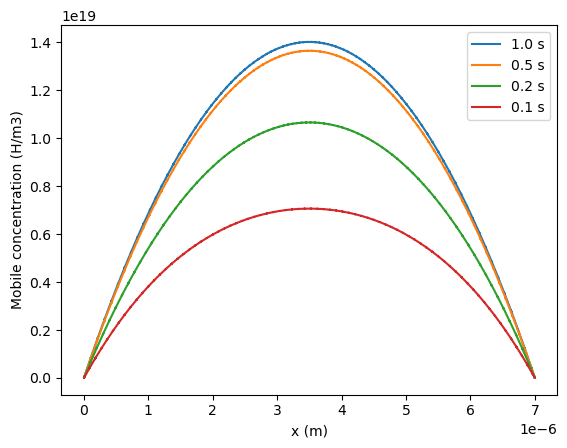

In [12]:
import matplotlib.pyplot as plt
import numpy as np

data = np.genfromtxt(
    results_folder + "/mobile_concentration.txt", skip_header=1, delimiter=","
)

plt.plot(data[:, 0], data[:, 4], label="1.0 s")
plt.plot(data[:, 0], data[:, 3], label="0.5 s")
plt.plot(data[:, 0], data[:, 2], label="0.2 s")
plt.plot(data[:, 0], data[:, 1], label="0.1 s")

plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.legend()
plt.show()

To solve the steady-state problem, simply set:

In [13]:
my_model.settings.transient = False
my_model.dt = None

my_model.exports = [
    F.TXTExport(
        field="solute", filename=results_folder + "/mobile_concentration_steady.txt"
    )
]

In [14]:
my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


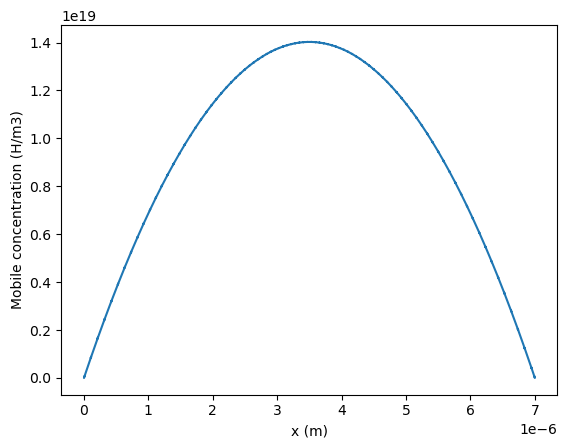

In [15]:
data = np.genfromtxt(
    results_folder + "/mobile_concentration_steady.txt", skip_header=1, delimiter=","
)

plt.plot(data[:, 0], data[:, 1])
plt.xlabel("x (m)")
plt.ylabel("Mobile concentration (H/m3)")
plt.show()